# Climate and vegetation

- Variables are: `NDVI_mm`, `SWVL1_mm`, `STL1_mm`, `WB_mm`, `WD_mm`, `TP_mm`, `E_mm`, `RELHUM_mm`, `SSR_mm`, and `T2M_mm`.
- `Spearman rank correlation` between vegetation and climate variables with and without lags.
- Detrend and normalize data before calculating Spearman rank correlation.
- Without lag.

## 1 Initial setup

In [ ]:
%load_ext autoreload
%autoreload 2

In [2]:
import warnings
warnings.filterwarnings("ignore")

In [3]:
# Load packages.
import sys
import glob

import xarray as xr
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates

from cartopy import crs as ccrs
from cartopy import feature as cfeature
from cartopy.io import shapereader
from cartopy.mpl.geoaxes import GeoAxes
from cartopy.mpl.ticker import LongitudeFormatter, LatitudeFormatter
from mpl_toolkits.axes_grid1 import AxesGrid

%matplotlib inline

In [4]:
# First we will use cartopy's shapereader to download (and cache) 
# states shapefile with 50 meters resolution from the NaturalEarth.
kw = dict(
    resolution="50m", 
    category="cultural", 
    name="admin_1_states_provinces"
)
states_shp = shapereader.natural_earth(**kw)
shp = shapereader.Reader(states_shp)

In [5]:
print(">>> Version of xarray:", xr.__version__)

>>> Version of xarray: 0.14.0


In [6]:
# My repository.
repository = "/home/alex/Dropbox/repositories/"

# Include once my repository in the path for searching libraries.
if repository not in sys.path:
    sys.path.append(repository)
    
# Import my package.
import cdlearn
from cdlearn.auxiliary import dict_units, dict_titles_pt

# Map borders.
loni, lonf, lati, latf = -90, -30, -60, 20

# Time range. The same as GIMMS ndvi.
ti, tf = "1981-07", "2015-12"

# Where figures will be put.
fig_path = "/home/alex/Dropbox/repositories/phd/images/"

## 2 Load monthly observed data

In [7]:
%%time

# Monthly means (mm).
var_labels = [
    "NDVI_mm", 
    "SWVL1_mm", 
    "STL1_mm", 
    "WB_mm",
    "WD_mm",
    "TP_mm", 
    "E_mm", 
    "RELHUM_mm", 
    "SSR_mm", 
    "T2M_mm"
]

codes = [
    "ndvi", 
    "swvl1", 
    "stl1", 
    "wb",
    "wd",
    "tp", 
    "e", 
    "relhum", 
    "ssr", 
    "t2m"
]

# South America.
region = {
    "loni": loni, 
    "lonf": lonf, 
    "lati": lati, 
    "latf": latf
}

# The same as GIMMS ndvi.
time_range = {
    "ti": ti, 
    "tf": tf
}

verbose = False
cd = cdlearn.pixels.ClimateData(
    var_labels=var_labels, 
    region=region,
    time_range=time_range,
    verbose=verbose
)

CPU times: user 10.6 s, sys: 143 ms, total: 10.7 s
Wall time: 10.9 s


**DANGER ZONE! Memory intensive operation**

In [8]:
%%time

DSs = cd.load_into_memory(verbose=verbose)

CPU times: user 25.4 s, sys: 2.37 s, total: 27.8 s
Wall time: 25.5 s


**ANOTHER DANGER ZONE!** 

**Must be careful with sign of evaporation data!**

In [9]:
DSs["E_mm"] = (-1) * DSs["E_mm"]

## 3 Detrend and normalize data

In [10]:
%%time

# Detrend and normalize the xarray DataArray objects.
DAs = {}

# Auxiliary dictionary.
dict_aux = {}
for var_label, code in zip(var_labels, codes):
    dict_aux[var_label] = code
    
# Loop over the xarray Dataset objects,
for var_label, DS in DSs.items():
    
    # Get xarray DataArray object.
    DA = getattr(DS, dict_aux[var_label])
    
    # Detrend data.
    DA = cdlearn.statistics.linear_detrend(DA)
    
    # Normalize data.
    DA = (DA - DA.mean("time")) / DA.std("time")
    
    # Append to dictionary of results.
    DAs[var_label] = DA

CPU times: user 6.17 s, sys: 128 ms, total: 6.3 s
Wall time: 3.37 s


## 4 Nonlinear correlations between variables (monthly data)

In [11]:
%%time

# Correlations between vegetation and climate detrended and normalized data.
rhos = []
for index, var_label in enumerate(var_labels):
    
    if index > 0: 
    
        # Select variables.
        da1 = DAs["NDVI_mm"] # Always ndvi.  
        da2 = DAs[var_label]
        
        # Linear relationship.
        rho = cdlearn.statistics.correlation(da1, da2, lag=0, method="spearman")

        # Put mask.
        rho = cdlearn.pixels.EraInterimGrid.add_land_mask(rho)
    
        # Add to list of results.
        rhos.append(rho)

CPU times: user 54.9 s, sys: 364 ms, total: 55.2 s
Wall time: 53.2 s


CPU times: user 5.68 s, sys: 75.9 ms, total: 5.76 s
Wall time: 5.76 s


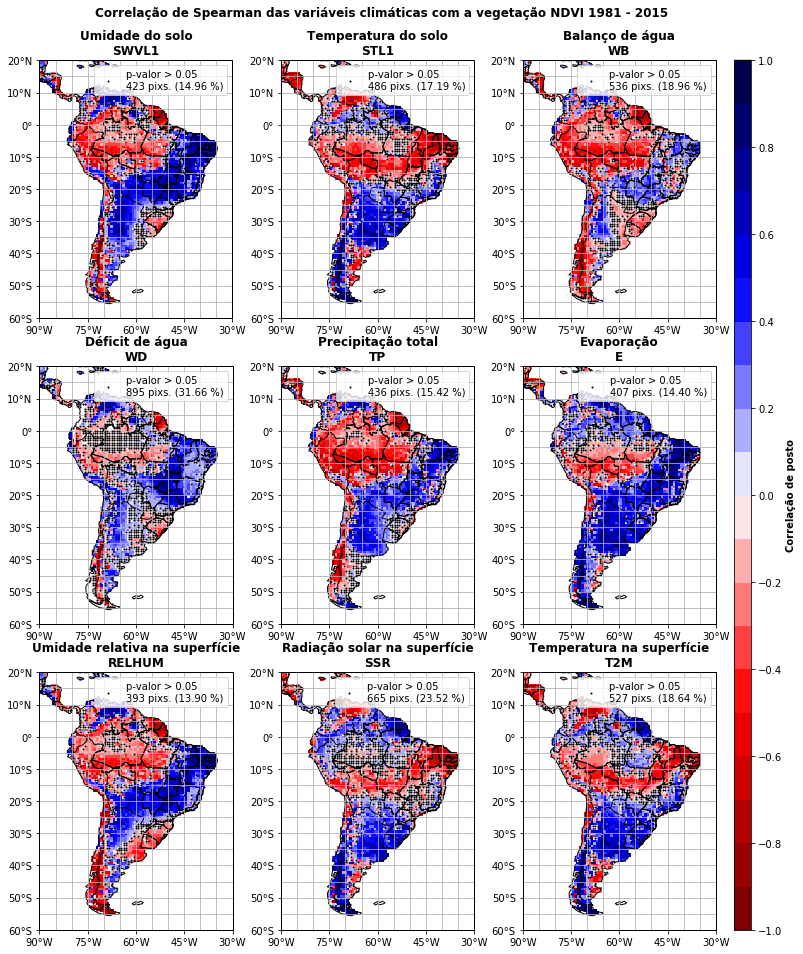

In [12]:
%%time

titles = [
    "Umidade do solo\n" + codes[1].upper(),
    "Temperatura do solo\n" + codes[2].upper(),
    "Balanço de água\n" + codes[3].upper(),
    "Déficit de água\n" + codes[4].upper(),
    "Precipitação total\n" + codes[5].upper(),
    "Evaporação\n" + codes[6].upper(),
    "Umidade relativa na superfície\n" + codes[7].upper(),
    "Radiação solar na superfície\n" + codes[8].upper(),
    "Temperatura na superfície\n" + codes[9].upper()
]

# Make grid object.
projection = ccrs.PlateCarree()
axes_class = (GeoAxes, dict(map_projection=projection))
fig = plt.figure(figsize=(15, 15))

axgr = AxesGrid(
    fig=fig, 
    rect=111, 
    axes_class=axes_class,
    nrows_ncols=(3, 3),
    axes_pad=0.675,
    cbar_location="right",
    cbar_mode="single",
    cbar_pad=0.25,
    cbar_size="3%",
    label_mode=""
)

# Make maps.
for index, axis in enumerate(axgr):
    axis.coastlines()
    axis.set_extent([loni, lonf, latf, lati], crs=projection)
    axis.add_feature(cfeature.BORDERS)
    axis.set_xticks(np.arange(-90, -15, 15), crs=projection)
    axis.set_yticks(np.arange(-60, 30, 10), crs=projection)
    lon_formatter = LongitudeFormatter(zero_direction_label=True)
    lat_formatter = LatitudeFormatter()
    axis.xaxis.set_major_formatter(lon_formatter)
    axis.yaxis.set_major_formatter(lat_formatter)
    axis.gridlines(xlocs=range(-90, -25, 5), ylocs=range(-60, 25, 5))        
   
    # Plot data on these maps.
    p = rhos[index].sel(stats="rho").where(rhos[index].land_mask == True).plot(
        ax=axis,
        vmin=-1.0,
        vmax=1.0,
        levels=np.arange(-1.0, 1.1, 0.1),
        cmap=plt.cm.seismic_r,
        add_colorbar=False,
        add_labels=False
    )

    axis.set_title(titles[index], weight="bold")
    
    # Brazilian states's boundaries.
    for state in shp.geometries():
        axis.add_geometries(
            geoms=[state], 
            crs=projection, 
            facecolor="none", 
            edgecolor="black"
        )    

    # Statistical significant trends.
    mask = rhos[index].sel(stats="p_value").where(rhos[index].land_mask == True) > 0.05
    LON, LAT = np.meshgrid(mask.longitude.values, mask.latitude.values)

    # Insignificant linear relations.
    only_land = (~mask.where(mask.land_mask==True).isnull()).sum().values
    axis.plot(LON[mask], LAT[mask], ".k", markersize=2, 
              label="p-valor > 0.05\n" + str(mask.sum().values) + " pixs. " + \
                    str("(%.2f %%)" %(mask.sum().values / only_land * 100)), 
              transform=projection)
    # Legend.    
    axis.legend(loc=1)     
        
# Fill common colorbar.        
cb = axgr.cbar_axes[0].colorbar(p)
cb.set_label_text("Correlação de posto", weight="bold")
cb.cbar_axis.set_ticks(np.arange(-1.0, 1.2, 0.2))        
plt.suptitle("Correlação de Spearman das variáveis climáticas com a vegetação NDVI" + \
             " 1981 - 2015", weight="bold")
plt.subplots_adjust(top=0.93)    

# Save figures.
plt.savefig(fig_path + "ndvi_climate_spearman_pt.jpg", dpi=200, bbox_inches="tight")